# HR Analytics: Job Change of Data Scientists

## Importing required libraries

In [229]:
#for algebra and data processing
import numpy as np
import pandas as pd

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
import plotly.express as px
import matplotlib.style as style
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve

#for prediction and preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

## Import datasets

**Dataset information:**
There are tow dataset files:
1. aug_train.csv : for training a model
2. aug_test.csv : for testing a model

**The dataset has following features:**
- enrollee_id : Unique ID for candidate
- city: City code
- city_ development _index : Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline :Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

In [230]:
# from google.colab import files
# uploaded = files.upload()

In [231]:
df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')

### Dataset inofrmation:

In [232]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [233]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [234]:
print("Train dataset size: ")
df_train.shape

Train dataset size: 


(19158, 14)

In [235]:
print("Test dataset size: ")
df_test.shape

Test dataset size: 


(2129, 13)

In [236]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [237]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


## Data Preprocessing

### Missing/Null values:

In [238]:
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [239]:
df_test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [240]:
missing = pd.concat([df_train.isnull().sum(), 100 * df_train.isnull().sum() / len(df_train)],
                   axis=1).rename(columns={0:'Missing records', 1:'Percentage(%)'}).sort_values(by='Percentage(%)', 
                                                                                                 ascending=False)

trace = go.Bar(y=missing.index[::-1], x=missing['Percentage(%)'][::-1],
              orientation='h', marker=dict(color='firebrick',))
data = [trace]
layout = dict(title = 'Percentage missing values:', margin = dict(l = 200))

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

### Data overview

In [241]:
display(df_train[['city','city_development_index','relevent_experience','gender','education_level',
                  'major_discipline','experience','company_size','company_type','target']
                ].groupby(['gender','education_level','experience','company_size']).agg(["max",'mean',"min"])
                .style.background_gradient(cmap="viridis"))

## Visualizations

1. Piechart: how many employees are looking for change?

In [242]:
tmp = df_train['target'].value_counts()

trace = go.Pie(labels=list(tmp.index), values=list(tmp.values))
layout = dict(title="How many employees are looking for change?")
fig = dict(data=[trace], layout=layout)

py.iplot(fig, filename="pie chart")

2. Countplots based on Educational level

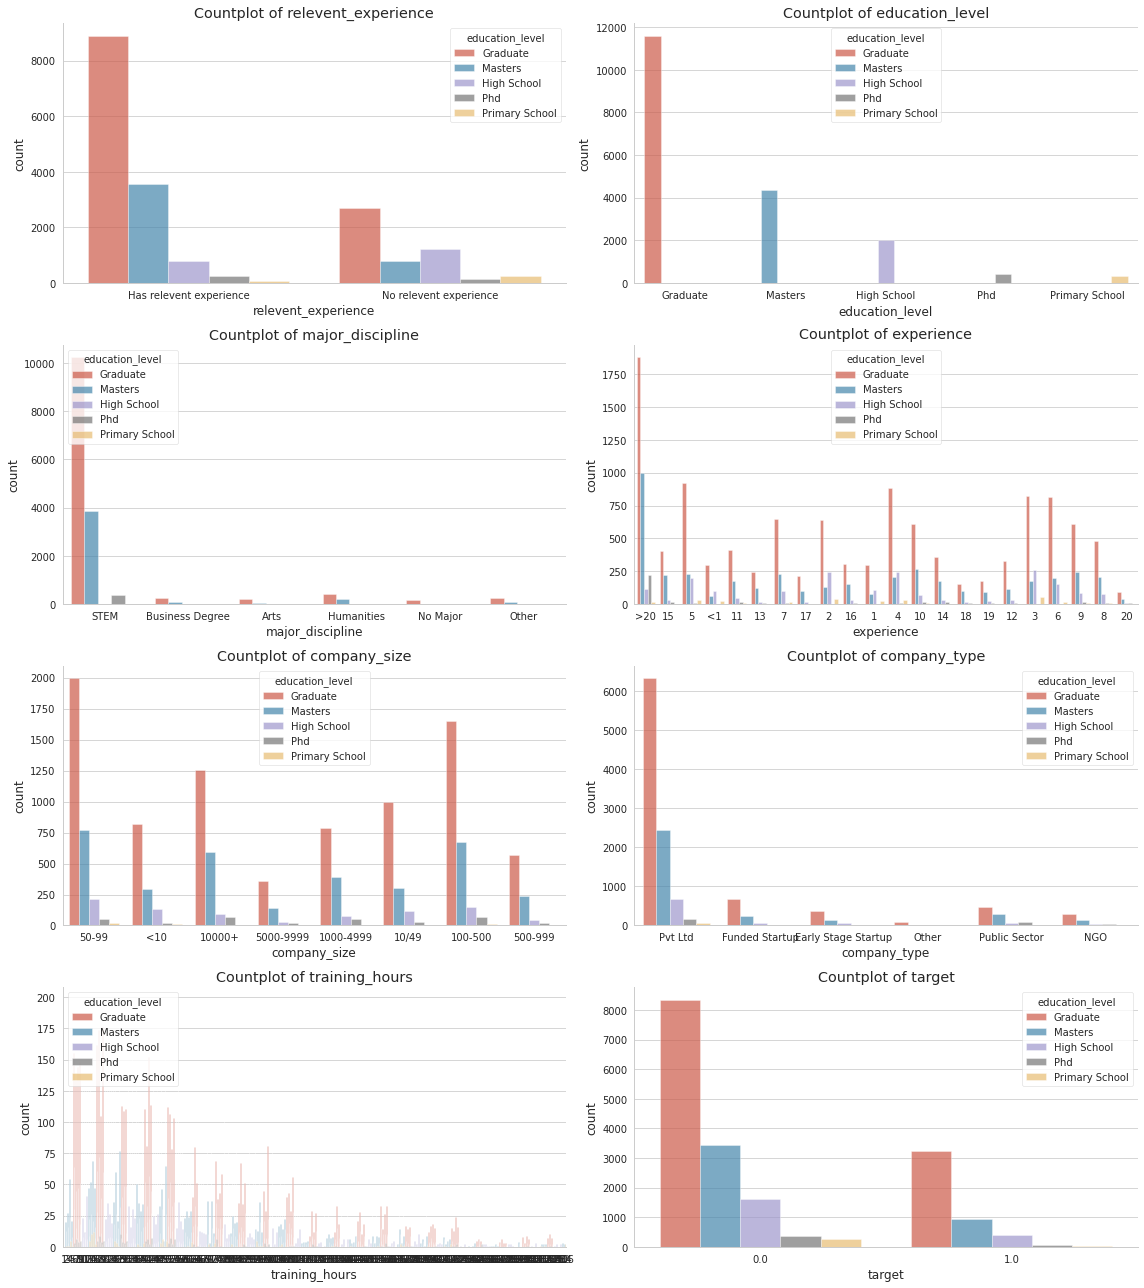

In [243]:
plt.figure(figsize=[16,18])
plot=["relevent_experience", "education_level","major_discipline", "experience","company_size","company_type", "training_hours","target"]

n=1
for f in plot:
  plt.subplot(4, 2, n)
  sns.countplot(x=f, hue='education_level', alpha=0.7, data=df_train)
  sns.despine()
  plt.title("Countplot of {}".format(f))
  n=n+1

plt.tight_layout()
plt.show()

3. Heatmap

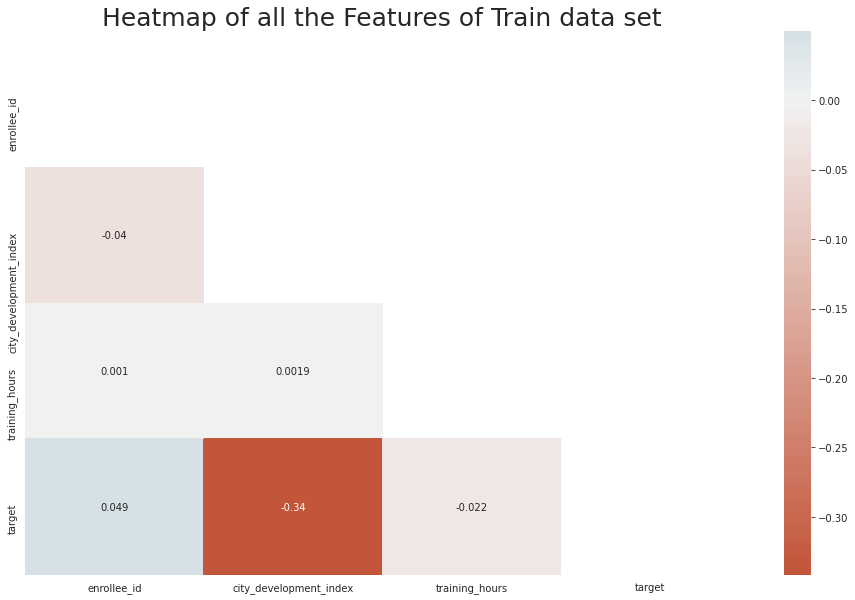

In [244]:
style.use('ggplot')
sns.set_style('whitegrid')

plt.subplots(figsize = (16,10))

mask = np.zeros_like(df_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_train.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

In [245]:
x = list(df_train.corr().columns)
y = list(df_train.corr().index)

values = np.array(df_train.corr().values)
fig = go.Figure(data=go.Heatmap(z=values, x=x, y=y, colorscale='matter', hoverongaps=False))

fig.show()

4. Box plot for training hours of employees:

In [246]:
px.box(data_frame=df_train, x='target', y='training_hours')

The number of training hours is same for both types of employees. thus it cannot help for prediction.

5. Box plot for city of employee

In [247]:
px.box(data_frame=df_train, x='target', y='city_development_index', color_discrete_sequence=px.colors.sequential.Rainbow)

The plot shows that if the index of the cities development is above 0.85, then the candidates may not change their jobs.

6. Piechart: education levels of employee

In [248]:
tmp = df_train['education_level'].value_counts().reset_index()
tmp.columns = ['education_level', 'percent']
tmp['percent']/=len(df_train)

fig = px.pie(tmp, names='education_level', values='percent', title='Education Levels of Employees',
             width=1000, height=600, color_discrete_sequence=px.colors.sequential.RdBu, hole=.4)

fig.show()

7. Piechart: Experience of employees

In [249]:
tmp = df_train['experience'].value_counts().reset_index()
tmp.columns = ['experience', 'percent']
tmp['percent']/=len(df_train)

fig = px.pie(tmp, names='experience', values='percent', title='Experience of Employees',
             width=1000, height=600, color_discrete_sequence=px.colors.sequential.haline)

fig.show()

8. Piechart: Company type

In [250]:
company_type = df_train[df_train['target'] == 1]['company_type']
tmp = company_type.value_counts().reset_index()
tmp.columns = ['company_type', 'percent']
tmp['percent']/=len(df_train)

fig = px.pie(tmp, names='company_type', values='percent', title='Company types that employees leave',
             width=1000, height=600, color_discrete_sequence=px.colors.sequential.Aggrnyl,
             hole=0.3)

fig.show()

9. Top cities related to job change

Text(0.5, 1.0, 'Top 5 cities where jobs are changed most frequently')

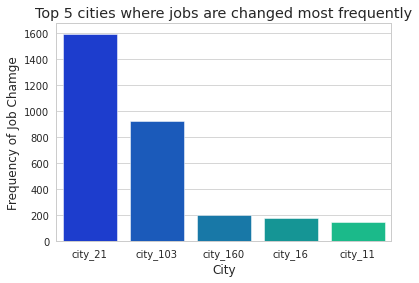

In [251]:
city_frequency = list()
unique_cities = df_train['city'].unique()

for city_id, city in enumerate(unique_cities):
    temp = df_train[(df_train['city'] == city) & (df_train['target'] == 1.0)]
    frequency = temp.shape[0]
    city_frequency.append([city, frequency])

city_data = pd.DataFrame(city_frequency, columns = ['city_name', 'frequency'])
sorted_city_frequency = city_data.sort_values(by = 'frequency', ascending = False)

top5 = sorted_city_frequency.iloc[:5, :]
sns.barplot(x = 'city_name', y='frequency', data = top5, palette='winter')

plt.xlabel('City')
plt.ylabel('Frequency of Job Chamge')
plt.title('Top 5 cities where jobs are changed most frequently')

10. Piechart: Impact of company size

In [252]:
tmp = df_train['company_size'].value_counts().reset_index()
tmp.columns = ['company_size', 'percent']
tmp['percent']/=len(df_train)

fig = px.pie(tmp, names='company_size', values='percent', title='Size of Company',
             width=1000, height=600, color_discrete_sequence=px.colors.sequential.Sunset,
             hole=.4)

fig.show()

## Preparing data for model

City code extracting

In [253]:
def code_ext(x):
    y = x.str.split("_",expand=True)[1].astype('int64')
    return y

df_train['city'] = code_ext(df_train['city'])

In [254]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Handling Missing values

In [255]:
def null_fill(x):
  return x.fillna('Unknown', inplace=True)

In [256]:
null_fill(df_train)

In [257]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  int64  
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(3), object(9)
mem

Encoding the data

In [258]:
ord_p = Pipeline([
    ('ord_encode',OrdinalEncoder([
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

ord_col = ['education_level','experience','company_size','last_new_job']

card_col = ['gender','relevent_experience','enrolled_university','major_discipline','company_type'] 

Encoder function

In [259]:
def encode(df, ord_col, card_col):
  ord_p.fit(df[ord_col])
  df[ord_col] = ord_p.transform(df[ord_col])
  
  df = pd.get_dummies(df, columns=card_col)
  return df

In [260]:
df_train = encode(df_train, ord_col, card_col)

In [261]:
df_train.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,gender_Male,gender_Other,gender_Unknown,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,enrolled_university_Full time course,enrolled_university_Part time course,enrolled_university_Unknown,enrolled_university_no_enrollment,major_discipline_Arts,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,major_discipline_Unknown,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,company_type_Unknown
0,8949,103,0.920,3.0,22.0,0.0,1.0,36,1.0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0.0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,11561,21,0.624,3.0,6.0,0.0,6.0,83,0.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,33241,115,0.789,3.0,1.0,0.0,6.0,52,1.0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0.0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0


Data Balancing

In [262]:
X = df_train.drop(columns=['enrollee_id','target'])
y = df_train.target

In [263]:
def balancing(X,y,smote_ratio,rus_ratio):
    smote = SMOTE(sampling_strategy=smote_ratio)
    X_sm, y_sm = smote.fit_sample(X, y)
    rus = RandomUnderSampler(sampling_strategy=rus_ratio)
    X, y = rus.fit_sample(X_sm,y_sm)
    return X,y

In [264]:
X,y = balancing(X,y,1,1)

In [265]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 14381, 1.0: 14381}

### Feature Selection

In [266]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)

cols = selector.get_support(indices=True)
X_new = X[:,cols]

## Modeling for predictions

In [267]:
#splitting data
X_train,X_test,y_train,y_test = train_test_split(X_new,y,test_size=0.2,stratify=y,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((23009, 10), (5753, 10), (23009,), (5753,))

In [268]:
#models function
models = Pipeline([
    ('clf', None), 
])

search = GridSearchCV(
    models, 
    cv=3, 
    return_train_score=False, 
    scoring=['accuracy', 'recall', 'f1'],
    refit = 'f1',
    param_grid={
        'clf': [GaussianNB(), RandomForestClassifier(), LogisticRegression(), XGBClassifier()]        
})

In [269]:
search.fit(X_train,y_train)

print('Best model:', search.best_params_)
model_comparison = pd.DataFrame(search.cv_results_)
model_comparison

Best model: {'clf': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.006898,0.001252,0.012101,0.000204,"GaussianNB(priors=None, var_smoothing=1e-09)","{'clf': GaussianNB(priors=None, var_smoothing=...",0.684224,0.676923,0.688095,0.683081,0.004632,4,0.666406,0.661490,0.665548,0.664481,0.002144,4,0.678439,0.669776,0.683011,0.677075,0.005488,4
1,1.435880,0.014900,0.161992,0.002649,"RandomForestClassifier(bootstrap=True, ccp_alp...","{'clf': RandomForestClassifier(bootstrap=True,...",0.827640,0.830900,0.827618,0.828719,0.001542,2,0.819770,0.802843,0.802686,0.808433,0.008017,2,0.826236,0.824659,0.824622,0.825172,0.000752,2
2,0.291326,0.009531,0.015014,0.000246,"LogisticRegression(C=1.0, class_weight=None, d...","{'clf': LogisticRegression(C=1.0, class_weight...",0.704302,0.712647,0.713783,0.710244,0.004227,3,0.710746,0.752830,0.727014,0.730197,0.017327,3,0.706141,0.721858,0.719489,0.715829,0.006918,3
3,0.773179,0.024811,0.036225,0.000500,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'clf': XGBClassifier(base_score=0.5, booster=...",0.835072,0.832203,0.845873,0.837716,0.005886,1,0.847939,0.844170,0.862087,0.851399,0.007713,1,0.837131,0.832879,0.849580,0.839863,0.007087,1


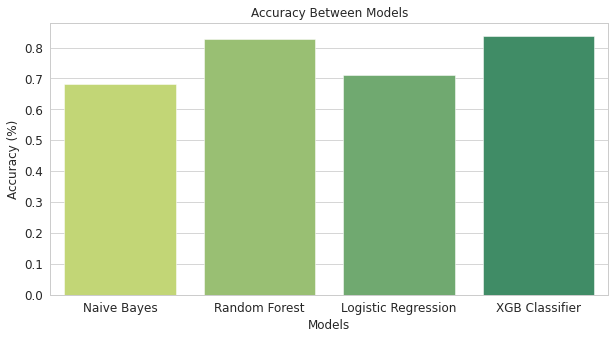

In [270]:
model_comparison['model'] = ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'XGB Classifier']

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot('model', 'mean_test_accuracy', data=model_comparison, capsize=.05, palette='summer_r', ci=None)
ax.set_xlabel("Models",fontsize=12)
ax.set_ylabel("Accuracy (%)",fontsize=12)
ax.tick_params(labelsize=12)
ax.axes.set_title("Accuracy Between Models", fontsize=12)

plt.show()